# **COMP9517 - Group Project (Segmentation Models Pytorch)**

## **0. Add Imports**

In [1]:
# !conda env create -f environment.yaml

In [2]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))

import torch
import matplotlib.pyplot as plt
import lightning as L
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader

from utils.data import USASegmentationDataModule
# import unet.config as config

from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping, ModelSummary
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger
from lightning_models.smp import SMPLightningModule
from lightning.pytorch.tuner import Tuner


## **1. Find Suggested Learning Rate**

In [3]:
data_module = USASegmentationDataModule(
    val_split=0.1, test_split=0.2, seed=42,
    pattern="merged", # in_channels=4. If pattern is "merged", it will use 4 channels (RGB + NIR); Otherwise, it will use 3 channels (RGB).
    batch_size=32,
    num_workers= 0,  # Set to 0 to avoid multiprocessing issues
    target_size=256)

In [4]:
model = SMPLightningModule(
    arch="Unet",
    encoder_name="se_resnet50",
    encoder_weights="imagenet",
    in_channels=data_module.in_channels,
    out_classes=1,  # Binary segmentation
    lr=1e-3,
    use_scheduler=False
)

layer_names = []
for name, module in model.model.encoder.named_children():
    layer_names.append(name)

In [5]:
for name, module in model.model.encoder.named_children():
    if name in layer_names[1:4]:  # Freeze the 2nd to 4th layers
        print(f"Freezing layer: {name}")
        for param in module.parameters():
            param.requires_grad = False

Freezing layer: layer1
Freezing layer: layer2
Freezing layer: layer3


In [6]:
trainer = L.Trainer()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


c:\Users\60956\.conda\envs\CVers\Lib\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\60956\.conda\envs\CVers\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\60956\.conda\envs\CVers\Lib\site-packages\lightning\pytorch\loops\fit_loo

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.004677351412871982
Restoring states from the checkpoint path at c:\Users\60956\OneDrive - UNSW\2025 T2\COMP9517 Computer Vision\Group Project\CV9517_Group-Project\notebooks\.lr_find_aebdc222-6f1e-480f-abd8-48532400f85a.ckpt
Restored all states from the checkpoint at c:\Users\60956\OneDrive - UNSW\2025 T2\COMP9517 Computer Vision\Group Project\CV9517_Group-Project\notebooks\.lr_find_aebdc222-6f1e-480f-abd8-48532400f85a.ckpt


Teardown called, cleaning up datasets...

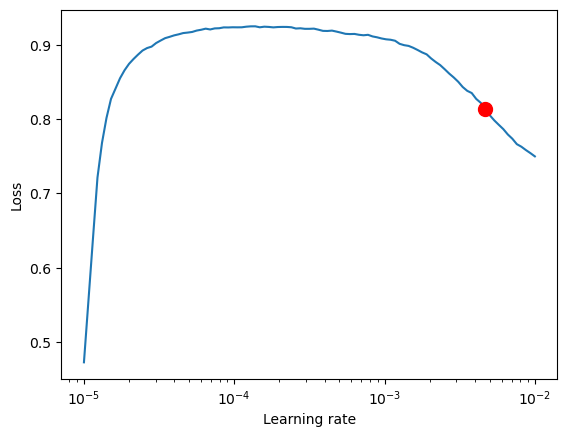

C:\Users\60956\AppData\Local\Temp\ipykernel_52276\878915357.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [7]:
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model, datamodule=data_module,
                          min_lr=1e-5, max_lr= 0.01,
                          num_training=100, early_stop_threshold=4)
fig = lr_finder.plot(suggest=True, show=True)
fig.show()

In [8]:
import math
suggested_lr = lr_finder.suggestion()
print(f"Original suggested learning rate: {suggested_lr}")

# Round the suggested learning rate to 1 significant digit
magnitude =  10 ** (math.floor(math.log10(suggested_lr)))
suggested_lr = round(suggested_lr / magnitude) * magnitude

print(f"Rounded suggested learning rate: {suggested_lr}")


Original suggested learning rate: 0.004677351412871982
Rounded suggested learning rate: 0.005


## **3. Train Segmentation Model**

In [9]:
home_dir = os.path.expanduser("~")
print(f"Home directory: {home_dir}")

Home directory: C:\Users\60956


In [10]:
data_module =  USASegmentationDataModule(
    val_split=0.1, test_split=0.2, seed=42,
    pattern="merged", # in_channels=4. If pattern is "merged", it will use 4 channels (RGB + NIR); Otherwise, it will use 3 channels (RGB).
    batch_size=32,
    num_workers= int(os.cpu_count() / 2) if os.cpu_count() is not None else 0,
    target_size=256)

In [ ]:
model_sum_callback = ModelSummary(max_depth=2)

lr_monitor = LearningRateMonitor(logging_interval='step')

early_stop_callback = EarlyStopping(
    monitor="val_per_image_iou",
    patience=10,
    verbose=True,
    mode="max"  # Maximize the metric
)

checkpoint_callback = ModelCheckpoint(
    dirpath="../checkpoints/smp_unet_se_resnet50/v2",
    filename="{epoch:02d}-{val_per_image_iou:.4f}-",
    monitor="val_per_image_iou",
    mode="max",
    save_top_k=3,
    save_on_train_epoch_end=True,
    enable_version_counter=True
)

In [12]:
model = SMPLightningModule(
    arch="Unet",
    encoder_name="se_resnet50",
    encoder_weights="imagenet",
    in_channels=data_module.in_channels,
    out_classes=1,  # Binary segmentation
    lr=suggested_lr,
    use_scheduler=True
)

layer_names = []
for name, module in model.model.encoder.named_children():
    layer_names.append(name)
print(f"Encoder layer names: {layer_names}")


Encoder layer names: ['layer0', 'layer1', 'layer2', 'layer3', 'layer4', 'layer0_pool']


In [13]:
for name, module in model.model.encoder.named_children():
    if name in layer_names[1:4]:  # Freeze the 2nd to 4th layers
        print(f"Freezing layer: {name}")
        for param in module.parameters():
            param.requires_grad = False

Freezing layer: layer1
Freezing layer: layer2
Freezing layer: layer3


In [14]:
logger = TensorBoardLogger("tb_logs/", name="smp_unet_se_resnet50", version="v2")

trainer = L.Trainer(
    max_epochs=100,
    enable_progress_bar=True,
    logger=logger,
    callbacks=[model_sum_callback,lr_monitor, early_stop_callback, checkpoint_callback],
)
trainer.fit(model, datamodule=data_module)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\60956\.conda\envs\CVers\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:658: Checkpoint directory C:\Users\60956\OneDrive - UNSW\2025 T2\COMP9517 Computer Vision\Group Project\CV9517_Group-Project\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
c:\Users\60956\.conda\envs\CVers\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.

  | Name                    | Type             | Params | Mode 
----------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\60956\.conda\envs\CVers\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_per_image_iou improved. New best score: 0.029


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_per_image_iou improved by 0.033 >= min_delta = 0.0. New best score: 0.062


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_per_image_iou improved by 0.078 >= min_delta = 0.0. New best score: 0.139


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_per_image_iou improved by 0.038 >= min_delta = 0.0. New best score: 0.178


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_per_image_iou improved by 0.012 >= min_delta = 0.0. New best score: 0.189


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_per_image_iou improved by 0.037 >= min_delta = 0.0. New best score: 0.226


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_per_image_iou improved by 0.055 >= min_delta = 0.0. New best score: 0.281


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_per_image_iou improved by 0.042 >= min_delta = 0.0. New best score: 0.323


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_per_image_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.324


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_per_image_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.328


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_per_image_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.333


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_per_image_iou improved by 0.031 >= min_delta = 0.0. New best score: 0.364


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_per_image_iou improved by 0.008 >= min_delta = 0.0. New best score: 0.372


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_per_image_iou improved by 0.016 >= min_delta = 0.0. New best score: 0.388


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_per_image_iou improved by 0.018 >= min_delta = 0.0. New best score: 0.406


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_per_image_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.408


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_per_image_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.410


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_per_image_iou did not improve in the last 10 records. Best score: 0.410. Signaling Trainer to stop.


Teardown called, cleaning up datasets...